# Descripción del proyecto:
Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

- Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra.
- Luego, observa los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.
Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

# Descripción de los datos:
Cada entrada de registro es una acción de usuario o un evento.

- EventName: nombre del evento.
- DeviceIDHash: identificador de usuario unívoco.
- EventTimestamp: hora del evento.
- ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

## Paso 1. Abrir el archivo de datos y leer la información general

In [85]:
# Importamos las librerías que vamos a necesitar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st 
import math as mth
from scipy.stats import ttest_ind

In [2]:
logs = pd.read_csv('Dataset/logs_exp_us.csv', sep= '\s', dtype={'EventName': 'category', 'ExpId': 'category'}, engine= 'python')

In [3]:
display(logs.head())
logs.info(memory_usage= 'deep')

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


### Conclusiones:
La columna de EventTimestamp no esta en el formato correcto (debemos cambiarlo a formato 'date') y otro punto es que no tenemos valores ausentes.

## Paso 2. Preparar los datos para el análisis

### 2.1 Cambia el nombre de las columnas de manera que sea conveniente para ti.

In [4]:
# Como son pocas columnas lo haré de manera manual 
logs.columns = ['event_name', 'user_id', 'full_date', 'group']
logs.head()

,event_name,user_id,full_date,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### 2.2 Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.

In [5]:
logs.isna().sum()

event_name    0
user_id       0
full_date     0
group         0
dtype: int64

In [6]:
print(logs.duplicated().sum())

# Revisamos en porcentaje
display(logs.duplicated().sum() / len(logs))

413


np.float64(0.0016917493425526163)

In [7]:
logs.drop_duplicates(inplace= True)
logs.reset_index(inplace= True, drop= True)

### 2.3 Agrega una columna de fecha y hora y una columna separada para las fechas.

In [8]:
logs['full_date'] = pd.to_datetime(logs['full_date'], unit= 's')
display(logs.head())
logs.info(memory_usage= 'deep')

,event_name,user_id,full_date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  category      
 1   user_id     243713 non-null  int64         
 2   full_date   243713 non-null  datetime64[ns]
 3   group       243713 non-null  category      
dtypes: category(2), datetime64[ns](1), int64(1)
memory usage: 4.2 MB


In [9]:
# Creamos las columnas de date y hour
logs['date'] = logs['full_date'].dt.date
logs['hour'] = logs['full_date'].dt.time


In [10]:
logs.head()

,event_name,user_id,full_date,group,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


### Conclusiones:
- Cambié los nombres de las columnas por los que creí más convenientes para recordar el contenido de la columna.
- Comprobamos que no hay valores ausentes y los valores repetidos representan un porcentaje demasiado pequeño para el total de datos, por lo tanto decidí simplemente eliminarlos.
- Se corrijió el formato de la columna ahora llamada 'full_date' y se crearon las dos nuevas columnas con la fecha y la hora.

## 3. Estudiar y comprobar los datos

### 3.1 ¿Cuántos eventos hay en los registros?

In [11]:
logs['event_name'].unique()

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

### 3.2 ¿Cuántos usuarios hay en los registros?

In [12]:
logs['user_id'].nunique()

7551

### 3.3 ¿Cuál es el promedio de eventos por usuario?

In [13]:
len(logs) / logs['user_id'].nunique()

32.27559263673685

### 3.4 ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora.

In [14]:
# Iniciamos por encontrar la fecha máxima y mínima
print(logs['date'].min(), logs['date'].max())

2019-07-25 2019-08-07


### 3.5 ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general.

<Axes: xlabel='date'>

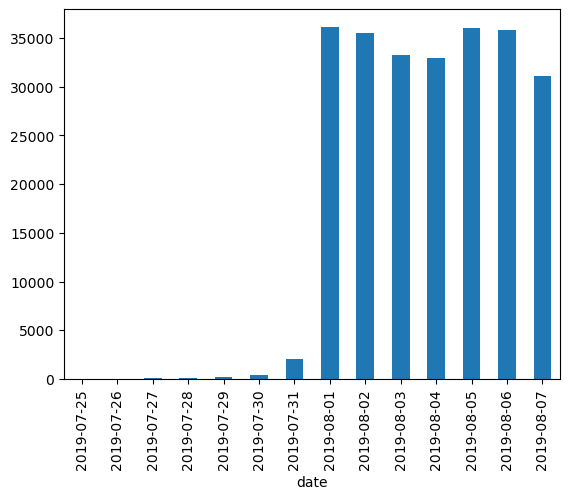

In [15]:
# Trazamos el histograma 
plt.Figure(figsize=(15, 5))

logs.groupby(['date'])['user_id'].count().plot(kind= 'bar')

Respuesta: Los datos anteriores al 2019-08-01 no tienen información suficiente para ser conciderada útil.

### 3.6 Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [16]:
# Filtro de momento en que los datos comienzan a estar completos
leaked_logs = logs[logs['date'] > pd.to_datetime('2019-07-31').date()]

Respuesta: El periodo que representa realmente los datos es del 2019-08-01 al 2019-08-07 (en el periodo de agosto).

### 3.7 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [17]:
loss_event = 100 * (1- len(leaked_logs) / len(logs))
loss_users = 100 * (1- leaked_logs['user_id'].nunique() / logs['user_id'].nunique())

print(f"Porcentaje de eventos perdido: {loss_event}")
print(f"Porcentaje de usuarios perdido: {loss_users}")

Porcentaje de eventos perdido: 1.159560630741896
Porcentaje de usuarios perdido: 0.22513574361011646


Respuesta: El porcentaje de los eventos perdidos es del 1.15% y el porcentaje de los usuarios perdidos es de 0.22%, estos son muy pocos tanto eventos como usuarios perdidos.

### 3.8 Asegúrate de tener usuarios de los tres grupos experimentales.

In [18]:
leaked_logs.groupby('group', observed= True)['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Respuesta: Sí tenemos usuarios en los tres grupos experimentales y son similares la cantidad de cada grupo.

### Conclusiones:
- Tenemos 7,551 usuarios en los registros y el promedio de eventos por usuario es de 32.2 eventos.
- El periodo que cubren los datos abarca del 2019-07-25 al 2019-08-07, sin embargo el periodo relevante, con datos útiles para poder realizar un correcto análisis es del 2019-08-01 al 2019-08-07.

## Paso 4. Estudiar el embudo de eventos

### 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [19]:
# Eventos en los registros
leaked_logs['event_name'].unique()

['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

In [20]:
# Frecuenia de sucesos
leaked_logs['event_name'].value_counts()

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: count, dtype: int64

### 4.2 Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [21]:
leaked_logs.groupby('event_name', observed= True)['user_id'].nunique().sort_values(ascending= False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

### 4.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

Respuesta: Las acciones creo que ocurrieron de las que tienen mayor cantidad de usuarios a la menor cantidad de usuarios (excepto Tutorial, este se encuentra fuera del embudo principal) como en el siguiente orden:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful

### 4.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [22]:
user_by_event = leaked_logs.groupby('event_name', observed= True)['user_id'].nunique().sort_values(ascending= False).reset_index()

# Creamos un desplazamiento de 1 en las columnas por parte del total de usuarios
user_by_event['users_by_previous_step'] = user_by_event['user_id'].shift(1)
user_by_event

,event_name,user_id,users_by_previous_step
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,7419.0
2,CartScreenAppear,3734,4593.0
3,PaymentScreenSuccessful,3539,3734.0
4,Tutorial,840,3539.0


In [23]:
# Calculamos la tasa de rentencion
user_by_event['retention_rate'] = user_by_event['user_id'] / user_by_event['users_by_previous_step']
user_by_event['dropoff'] = 1 - user_by_event['retention_rate']

user_by_event



,event_name,user_id,users_by_previous_step,retention_rate,dropoff
0,MainScreenAppear,7419,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,0.619086,0.380914
2,CartScreenAppear,3734,4593.0,0.812976,0.187024
3,PaymentScreenSuccessful,3539,3734.0,0.947777,0.052223
4,Tutorial,840,3539.0,0.237355,0.762645


In [24]:
# Graficamos el embudo para mayor claridad 
fig = go.Figure(go.Funnel(
                y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
                x = [7419, 4593, 3734, 3539],
                textinfo = "value + percent initial"))

fig.show()

### 4.5 ¿En qué etapa pierdes más usuarios?

Respuesta: En la etapa del MainScreenAppear a OffersScreenAppear.

### 4.6 ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

Respuesta: Un 48% de los usuarios hace todo el viaje.

### Conclusiones:
Tenemos los siguiente cantidad de usuarios por cada evento del embudo:
- MainScreenAppear---7419
- OffersScreenAppear---4593
- CartScreenAppear---3734
- PaymentScreenSuccessful---3539
- Tutorial lo omitimos porque no forma parte del embudo principal.

Al finalizar el análisis correspondiente obtuvimos información valiosa que nos puede dar un mejor panorama de como están fluyendo los clientes y poder abordar alguna mejora con una base solida para promover la mejora:
- La etapa donde se pierden más clientes es durante MainScreenAppear a OffersScreenAppear con un baja del 38% de los clientes. (Tal vez con un análisis basado en eventos podríamos profundizar en este tema).
- El porcentaje de los usuarios que hacen todo el recorrido, es bueno, de un 48%, ¡esto nos dice que casi la mitad de los usuarios que visitan la página realizan una compra! 

## Paso 5. Estudiar los resultados del experimento

### 5.1 ¿Cuántos usuarios hay en cada grupo?

In [25]:
leaked_logs.groupby('group', observed= True)['user_id'].count()

group
246    79302
247    77022
248    84563
Name: user_id, dtype: int64

### 5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [26]:
# Necesitamos la información de conversión de usuario
# Primero, revisamos los usuarios que están en cada grupo
user_in_group = leaked_logs[['user_id', 'group']].drop_duplicates().reset_index(drop= True)
user_in_group

,user_id,group
0,3737462046622621720,246
1,1433840883824088890,247
2,4899590676214355127,247
3,1182179323890311443,246
4,4613461174774205834,248
...,...,...
7529,5811573131275421338,248
7530,5365227480683749189,248
7531,6660805781687343085,246
7532,7823752606740475984,246


In [92]:
# Convertimos los usuarios que llegaron hasta el pago 
user_convertion_payment = leaked_logs[leaked_logs['event_name'] == 'PaymentScreenSuccessful']['user_id'].unique()
user_convertion_payment

array([4613461174774205834, 2712290788139738557, 6049698452889664846, ...,
       1309234519709630135, 7823752606740475984, 4164287718073415198])

In [95]:
# Genermos un DataFrame para poder unirlo a user_in_group y tener toda la info completa
df_convertion_1 = pd.DataFrame(data = {
    'user_id': user_convertion_payment,
    'converter': 1
})

# Ahora unimos los dos DataFrame
convertion_payment = user_in_group.merge(df_convertion_1, on= 'user_id', how= 'left')
convertion_payment.fillna({'converter': 0}, inplace=True)
convertion_payment

,user_id,group,converter
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,0.0
7530,5365227480683749189,248,0.0
7531,6660805781687343085,246,0.0
7532,7823752606740475984,246,1.0


### Generamos nuestra hipótesis:
- H0 : La tasa de conversión promedio al evento PaymentScreenSuccessful de los grupos 246 y 247 es igual.
- H1 : La tasa de conversión promedio al evento PaymentScreenSuccessful de los grupos 246 y 247 es diferenta.
- Alfa = 0.05


In [94]:
# Grupo 246
group_246 = convertion_payment[convertion_payment['group'] == '246']
n1 = len(group_246)
x1 = group_246['converter'].sum() 
p1 = x1 / n1
print(f"El total de usuarios del grupo 246 = {n1}")
print(f"Usuarios que convirtieron en grupo 246 = {x1} ")
print(f"La proporción de conversión del grupo 246 = {p1} ")

# Grupo 247
group_247 = convertion_payment[convertion_payment['group'] == '247']
n2 = len(group_247) 
x2 = group_247['converter'].sum()  
p2 = x2 / n2  
print(f"El total de usuarios del grupo 247 = {n2}")
print(f"Usuarios que convirtieron en grupo 247 = {x2} ")
print(f"La proporción de conversión del grupo 247 = {p2} ")

alpha = 0.05

El total de usuarios del grupo 246 = 2484
Usuarios que convirtieron en grupo 246 = 1200.0 
La proporción de conversión del grupo 246 = 0.4830917874396135 
El total de usuarios del grupo 247 = 2513
Usuarios que convirtieron en grupo 247 = 1158.0 
La proporción de conversión del grupo 247 = 0.46080382013529647 


Tenemos una proporción de conversión del grupo 246 del 48.3% y del grupo 247 del 46.0%, hay una diferencia de 2.3%, ahora veremos si es una diferencia estadísticamente significativa o si fue producto del azar.

In [ ]:
# Proporción pooled
p_pooled = (x1 + x2) / (n1 + n2)
print(f"Proporción combinada: {p_pooled}")

Proporción combinada: 0.47188312987792674


In [86]:
# Error estándar
SE = mth.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
print(f"Error estándar: {SE}")

Error estándar: 0.014124233242070591


In [87]:
# Estadístico z
z_stat = (p1 - p2) / SE
print(f"Estadístico z: {z_stat}")

Estadístico z: 1.5779948491596598


In [90]:
# P-value para prueba de dos colas
p_value = (1 - st.norm.cdf(abs(z_stat))) * 2
print(f"P-value: {p_value}")

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

P-value: 0.11456679313141849
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


### Conclusiones:
El valor p fue mayor que nuestro alpha del 5%, de acuerdo al planteamiento de nuesta hipótesis esto nos dice que no rechazamos la hipótesis nula, por lo tanto:
- No hay evidencia estadísticamente significativa de que las proporciones de conversión al evento PaymentScreenSuccessful entre los grupos 246 y 247 sean diferentes
- Los grupos de control se comportan de manera similar, como debería ser en un test A/A
- Esto valida que la división de usuarios en grupos fue correcta.

### 5.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [110]:
# Creamos la función 
def z_test_proporciones(grupo_1, grupo_2, event, alpha=0.05):
    """
    Parámetros:
    - grupo_1: DataFrame del primer grupo
    - grupo_2: DataFrame del segundo grupo  
    - event: evento que alcanzaron los usuarios para analizar
    - alpha: nivel de significancia
    """
    # Variables globales que necesitamos
    global leaked_logs, user_in_group
    
    # Filtrar usuarios que alcanzaron el evento
    user_convertion_event = leaked_logs[leaked_logs['event_name'] == event]['user_id'].unique()

    df_convertion = pd.DataFrame(data={
        'user_id': user_convertion_event,
        'converter': 1
    })

    # Merge para identificar conversiones
    convertion = user_in_group.merge(df_convertion, on='user_id', how='left')
    convertion.fillna({'converter': 0}, inplace=True)

    # Filtrar por grupo dentro de convertion
    group_1_conv = convertion[convertion['user_id'].isin(grupo_1['user_id'])]
    group_2_conv = convertion[convertion['user_id'].isin(grupo_2['user_id'])]

    # Cálculos para grupo 1
    n1 = len(group_1_conv)
    x1 = group_1_conv['converter'].sum() 
    p1 = x1 / n1
   
    # Cálculos para grupo 2
    n2 = len(group_2_conv) 
    x2 = group_2_conv['converter'].sum()  
    p2 = x2 / n2  

    # Proporción combinada
    p_pooled = (x1 + x2) / (n1 + n2)

    # Error estándar
    SE = mth.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

    # Estadístico Z
    z_stat = (p1 - p2) / SE

    # P-value (bilateral)
    p_value = (1 - st.norm.cdf(abs(z_stat))) * 2
    
    # Imprimir resultados
    print("=" * 60)
    print(f"Evento analizado: {event}")
    print(f"Grupo 1 - n: {n1}, conversiones: {x1}, proporción: {p1:.4f} ({p1*100:.2f}%)")
    print(f"Grupo 2 - n: {n2}, conversiones: {x2}, proporción: {p2:.4f} ({p2*100:.2f}%)")
    print(f"Diferencia: {(p1-p2)*100:.2f}%")
    print(f"Estadístico Z: {z_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Alpha: {alpha}")
    print("=" * 60)

    if p_value < alpha:
        print("Rechazar hipótesis nula")
        print("Hay una diferencia estadísticamente significativa entre las proporciones")
    else:
        print("No se rechaza la hipótesis nula")
        print("No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones")
    print("=" * 60)
    
    # Retornar resultados para uso posterior
    return {
        'n1': n1, 'x1': x1, 'p1': p1,
        'n2': n2, 'x2': x2, 'p2': p2,
        'z_stat': z_stat,
        'p_value': p_value,
        'rechazar_h0': p_value < alpha
    }

In [111]:
# Data frames de usuarios por grupo
group_246 = user_in_group[user_in_group['group'] == '246']
group_247 = user_in_group[user_in_group['group'] == '247']

Todas las siguientes pruebas son aplicando la siguiente hipótesis:
- H0 : La tasa de conversión promedio del "evento" de los grupos 246 y 247 es igual.
- H1 : La tasa de conversión promedio del "evento" de los grupos 246 y 247 es diferenta.
- Alfa = 0.05

In [112]:
# Para el evento MainScreenAppear
resultado_MainScreenAppear = z_test_proporciones(group_246, group_247, 'MainScreenAppear', alpha=0.05)

Evento analizado: MainScreenAppear
Grupo 1 - n: 2484, conversiones: 2450.0, proporción: 0.9863 (98.63%)
Grupo 2 - n: 2513, conversiones: 2476.0, proporción: 0.9853 (98.53%)
Diferencia: 0.10%
Estadístico Z: 0.3093
P-value: 0.7571
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [113]:
# Para el evento OffersScreenAppear
resultado_OffersScreenAppear = z_test_proporciones(group_246, group_247, 'OffersScreenAppear', alpha=0.05)

Evento analizado: OffersScreenAppear
Grupo 1 - n: 2484, conversiones: 1542.0, proporción: 0.6208 (62.08%)
Grupo 2 - n: 2513, conversiones: 1520.0, proporción: 0.6049 (60.49%)
Diferencia: 1.59%
Estadístico Z: 1.1550
P-value: 0.2481
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [114]:
# Para el evento CartScreenAppear
resultado_CartScreenAppear = z_test_proporciones(group_246, group_247, 'CartScreenAppear', alpha=0.05)

Evento analizado: CartScreenAppear
Grupo 1 - n: 2484, conversiones: 1266.0, proporción: 0.5097 (50.97%)
Grupo 2 - n: 2513, conversiones: 1238.0, proporción: 0.4926 (49.26%)
Diferencia: 1.70%
Estadístico Z: 1.2034
P-value: 0.2288
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


### Conclusión:
En ninguno de los eventos hay una diferencia estadísticamente significativa, por lo tanto, podemos decir que los grupos se dividieron correctamente y se comportan de manera similar como debería ser una prueba A/A. 

### 5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

Utilizaremos la misma función que realizamos en el ejercicio anterior

In [117]:
# DataFrame del grupo 248
group_248 = user_in_group[user_in_group['group'] == '248']

Los siguientes 4 son para la comparación entre el grupo 246 y el grupo 248:

In [128]:
# Para el evento MainScreenAppear
resultado_MainScreenAppear_1 = z_test_proporciones(group_246, group_248, 'MainScreenAppear', alpha=0.05)

Evento analizado: MainScreenAppear
Grupo 1 - n: 2484, conversiones: 2450.0, proporción: 0.9863 (98.63%)
Grupo 2 - n: 2537, conversiones: 2493.0, proporción: 0.9827 (98.27%)
Diferencia: 0.37%
Estadístico Z: 1.0473
P-value: 0.2950
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [129]:
# Para el evento OffersScreenAppear
resultado_OffersScreenAppear_1 = z_test_proporciones(group_246, group_248, 'OffersScreenAppear', alpha=0.05)

Evento analizado: OffersScreenAppear
Grupo 1 - n: 2484, conversiones: 1542.0, proporción: 0.6208 (62.08%)
Grupo 2 - n: 2537, conversiones: 1531.0, proporción: 0.6035 (60.35%)
Diferencia: 1.73%
Estadístico Z: 1.2581
P-value: 0.2084
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [130]:
# Para el evento CartScreenAppear
resultado_CartScreenAppear_1 = z_test_proporciones(group_246, group_248, 'CartScreenAppear', alpha=0.05)

Evento analizado: CartScreenAppear
Grupo 1 - n: 2484, conversiones: 1266.0, proporción: 0.5097 (50.97%)
Grupo 2 - n: 2537, conversiones: 1230.0, proporción: 0.4848 (48.48%)
Diferencia: 2.48%
Estadístico Z: 1.7599
P-value: 0.0784
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [131]:
# Para el evento PaymentScreenSuccessful
resultado_PaymentScreenSuccessful_1 = z_test_proporciones(group_246, group_248, 'PaymentScreenSuccessful', alpha=0.05)

Evento analizado: PaymentScreenSuccessful
Grupo 1 - n: 2484, conversiones: 1200.0, proporción: 0.4831 (48.31%)
Grupo 2 - n: 2537, conversiones: 1181.0, proporción: 0.4655 (46.55%)
Diferencia: 1.76%
Estadístico Z: 1.2474
P-value: 0.2123
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


Los siguientes 4 son para para la comparación entre el grupo 247 y el grupo 248:

In [132]:
# Para el evento MainScreenAppear
resultado_MainScreenAppear_2 = z_test_proporciones(group_247, group_248, 'MainScreenAppear', alpha=0.05)

Evento analizado: MainScreenAppear
Grupo 1 - n: 2513, conversiones: 2476.0, proporción: 0.9853 (98.53%)
Grupo 2 - n: 2537, conversiones: 2493.0, proporción: 0.9827 (98.27%)
Diferencia: 0.26%
Estadístico Z: 0.7410
P-value: 0.4587
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [133]:
# Para el evento OffersScreenAppear
resultado_OffersScreenAppear_2 = z_test_proporciones(group_247, group_248, 'OffersScreenAppear', alpha=0.05)

Evento analizado: OffersScreenAppear
Grupo 1 - n: 2513, conversiones: 1520.0, proporción: 0.6049 (60.49%)
Grupo 2 - n: 2537, conversiones: 1531.0, proporción: 0.6035 (60.35%)
Diferencia: 0.14%
Estadístico Z: 0.1007
P-value: 0.9198
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [134]:
# Para el evento CartScreenAppear
resultado_CartScreenAppear_2 = z_test_proporciones(group_247, group_248, 'CartScreenAppear', alpha=0.05)

Evento analizado: CartScreenAppear
Grupo 1 - n: 2513, conversiones: 1238.0, proporción: 0.4926 (49.26%)
Grupo 2 - n: 2537, conversiones: 1230.0, proporción: 0.4848 (48.48%)
Diferencia: 0.78%
Estadístico Z: 0.5554
P-value: 0.5786
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [135]:
# Para el evento PaymentScreenSuccessful
resultado_PaymentScreenSuccessful_2 = z_test_proporciones(group_247, group_248, 'PaymentScreenSuccessful', alpha=0.05)

Evento analizado: PaymentScreenSuccessful
Grupo 1 - n: 2513, conversiones: 1158.0, proporción: 0.4608 (46.08%)
Grupo 2 - n: 2537, conversiones: 1181.0, proporción: 0.4655 (46.55%)
Diferencia: -0.47%
Estadístico Z: -0.3354
P-value: 0.7373
Alpha: 0.05
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


### Conclusiones:
Al realizar el z-test comparando cada uno de los grupos (A/A) con el grupo (B) para cada uno de los eventos obtuvimos lo siguiente:
- En ninguno de los casos la diferencia de conversión supera el 2% entre un grupo y otro.
- En todas las pruebas el p-value salió superios a alfa, por lo tanto,
- no se rechazó la hipótesis nula en ningún evento,
- no tenemos evidencia suficiente de diferencia estadísticamente significativa entre las proporciones.

Por lo tanto, de acuero al análisis realizado y los resultados arrojados, aconsejamos que no tiene caso implementar los cambios del grupo de prueba porque al parecer no mejora nada.  

### 5.5 ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

Cambiamos el nivel de significancia alfa al 10%

Iniciamos comparando los grupos 246 y 248:

In [144]:
# Para el evento MainScreenAppear
resultado_MainScreenAppear_3 = z_test_proporciones(group_246, group_248, 'MainScreenAppear', alpha=0.10)

Evento analizado: MainScreenAppear
Grupo 1 - n: 2484, conversiones: 2450.0, proporción: 0.9863 (98.63%)
Grupo 2 - n: 2537, conversiones: 2493.0, proporción: 0.9827 (98.27%)
Diferencia: 0.37%
Estadístico Z: 1.0473
P-value: 0.2950
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [140]:
# Para el evento OffersScreenAppear
resultado_OffersScreenAppear_3 = z_test_proporciones(group_246, group_248, 'OffersScreenAppear', alpha=0.10)

Evento analizado: OffersScreenAppear
Grupo 1 - n: 2484, conversiones: 1542.0, proporción: 0.6208 (62.08%)
Grupo 2 - n: 2537, conversiones: 1531.0, proporción: 0.6035 (60.35%)
Diferencia: 1.73%
Estadístico Z: 1.2581
P-value: 0.2084
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [141]:
# Para el evento CartScreenAppear
resultado_CartScreenAppear_3 = z_test_proporciones(group_246, group_248, 'CartScreenAppear', alpha=0.10)

Evento analizado: CartScreenAppear
Grupo 1 - n: 2484, conversiones: 1266.0, proporción: 0.5097 (50.97%)
Grupo 2 - n: 2537, conversiones: 1230.0, proporción: 0.4848 (48.48%)
Diferencia: 2.48%
Estadístico Z: 1.7599
P-value: 0.0784
Alpha: 0.1
Rechazar hipótesis nula
Hay una diferencia estadísticamente significativa entre las proporciones


In [143]:
# Para el evento PaymentScreenSuccessful
resultado_PaymentScreenSuccessful_3 = z_test_proporciones(group_246, group_248, 'PaymentScreenSuccessful', alpha=0.10)

Evento analizado: PaymentScreenSuccessful
Grupo 1 - n: 2484, conversiones: 1200.0, proporción: 0.4831 (48.31%)
Grupo 2 - n: 2537, conversiones: 1181.0, proporción: 0.4655 (46.55%)
Diferencia: 1.76%
Estadístico Z: 1.2474
P-value: 0.2123
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


Ahora comparamos el grupo 247 con el grupo 248, en un nivel de significancia del 10%:

In [147]:
# Para el evento MainScreenAppear
resultado_MainScreenAppear_4 = z_test_proporciones(group_247, group_248, 'MainScreenAppear', alpha=0.10)

Evento analizado: MainScreenAppear
Grupo 1 - n: 2513, conversiones: 2476.0, proporción: 0.9853 (98.53%)
Grupo 2 - n: 2537, conversiones: 2493.0, proporción: 0.9827 (98.27%)
Diferencia: 0.26%
Estadístico Z: 0.7410
P-value: 0.4587
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [148]:
# Para el evento OffersScreenAppear
resultado_OffersScreenAppear_4 = z_test_proporciones(group_247, group_248, 'OffersScreenAppear', alpha=0.10)

Evento analizado: OffersScreenAppear
Grupo 1 - n: 2513, conversiones: 1520.0, proporción: 0.6049 (60.49%)
Grupo 2 - n: 2537, conversiones: 1531.0, proporción: 0.6035 (60.35%)
Diferencia: 0.14%
Estadístico Z: 0.1007
P-value: 0.9198
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [149]:
# Para el evento CartScreenAppear
resultado_CartScreenAppear_4 = z_test_proporciones(group_247, group_248, 'CartScreenAppear', alpha=0.10)

Evento analizado: CartScreenAppear
Grupo 1 - n: 2513, conversiones: 1238.0, proporción: 0.4926 (49.26%)
Grupo 2 - n: 2537, conversiones: 1230.0, proporción: 0.4848 (48.48%)
Diferencia: 0.78%
Estadístico Z: 0.5554
P-value: 0.5786
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


In [150]:
# Para el evento PaymentScreenSuccessful
resultado_PaymentScreenSuccessful_4 = z_test_proporciones(group_247, group_248, 'PaymentScreenSuccessful', alpha=0.10)

Evento analizado: PaymentScreenSuccessful
Grupo 1 - n: 2513, conversiones: 1158.0, proporción: 0.4608 (46.08%)
Grupo 2 - n: 2537, conversiones: 1181.0, proporción: 0.4655 (46.55%)
Diferencia: -0.47%
Estadístico Z: -0.3354
P-value: 0.7373
Alpha: 0.1
No se rechaza la hipótesis nula
No hay evidencia suficiente de diferencia estadísticamente significativa entre las proporciones


### Conclusiones:
De las 8 pruebas de z-test que realicé con nivel de significancia del 0.1:
- 7 arrojaron el mismo resultado de no rechazar la hipótesis nula,
- 1 arrojó que deberíamos rechazar la hipótesis nula(evento= CartScreenAppear, comparación= grupo 246 con 248)
Podemos decir que es un resultado falso, como se menciona en la redacción del problema.

## Conclusiones finales:
Después de haber realizado todas las pruebas necesarias para revisar los eventos, sus tipos de conversiones y la diferencia estadísticamente significativa entre todos los grupos con alfa 0.05 y alfa 0.10, podemos decir que:
- No es necesario implementar los cambios propuestos en el grupo B, debido a que no se puede probar una diferencia significativa entre los grupos.